## Step 1: Problem formulation

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from ema_workbench import (Model, CategoricalParameter, ScalarOutcome, IntegerParameter, RealParameter)
from ema_workbench import (Model, MultiprocessingEvaluator, SequentialEvaluator, Policy, Scenario)
from dike_model_function import DikeNetwork 

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
import time
from problem_formulation import get_model_for_problem_formulation

ema_logging.log_to_stderr(ema_logging.INFO)

#choose problem formulation number, between 0-5
#each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(7)

def sum_over(*args):
    return sum(args)

## Step 2: Searching for candidate solutions

In [2]:
# Even snelle check of het model goed is ingedalen
from ema_workbench.util import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO)

with SequentialEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=3, policies=3)
    
experiments, outcomes = results

[MainProcess/INFO] performing 3 scenarios * 3 policies * 1 model(s) = 9 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] 2 cases completed
[MainProcess/INFO] 3 cases completed
[MainProcess/INFO] 4 cases completed
[MainProcess/INFO] 5 cases completed
[MainProcess/INFO] 6 cases completed
[MainProcess/INFO] 7 cases completed
[MainProcess/INFO] 8 cases completed
[MainProcess/INFO] 9 cases completed
[MainProcess/INFO] experiments finished


In [3]:
#deze duurde 3,5 uur om te runnen bij Maarten; kan de results ook inladen via Excel
from ema_workbench.em_framework.evaluators import BaseEvaluator
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
optimize_min = [0,0,0,0]
optimize_max = [5e9, 1 ,1e9, 1e7]
optimize_epsilon = [1e7,1e-2,1e7, 1e5]

convergence_metrics = [HyperVolume(minimum=optimize_min, maximum=optimize_max),
                       EpsilonProgress()]

# with MultiprocessingEvaluator(dike_model) as evaluator: #staat nog op sequential!!!
#     results1, convergence = evaluator.optimize(nfe=15000, searchover='levers', epsilons=optimize_epsilon, 
#                                               convergence=convergence_metrics) #hier moet denk ik nog de uncertainty space bij

# results1.to_excel('./export/resultsoptimize_results.xlsx')
# convergence.to_excel('./export/resultsoptimizeconvergence.xlsx')

# result_statistics = pd.DataFrame()
# result_statistics['mean']=(np.mean(results1))
# result_statistics['std']=(np.std(results1))
# result_statistics['min']=(np.min(results1))
# result_statistics['max']=(np.max(results1))
# result_statistics.to_excel('./export/resultsoptimizestatistics.xlsx')

results1 = pd.read_excel('./export/resultsoptimize_results.xlsx', index_col=0, )
convergence = pd.read_excel('./export/resultsoptimizeconvergence.xlsx', index_col=0, )
result_statistics = pd.read_excel('./export/resultsoptimizestatistics.xlsx', index_col=0, )

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/15000 nfe
[MainProcess/INFO] generation 5: 500/15000 nfe
[MainProcess/INFO] generation 10: 995/15000 nfe
[MainProcess/INFO] generation 15: 1494/15000 nfe
[MainProcess/INFO] generation 20: 1991/15000 nfe
[MainProcess/INFO] generation 25: 2486/15000 nfe
[MainProcess/INFO] generation 30: 2980/15000 nfe
[MainProcess/INFO] generation 35: 3479/15000 nfe
[MainProcess/INFO] generation 40: 3974/15000 nfe
[MainProcess/INFO] generation 45: 4471/15000 nfe
[MainProcess/INFO] generation 50: 4970/15000 nfe
[MainProcess/INFO] generation 55: 5467/15000 nfe
[MainProcess/INFO] generation 60: 5963/15000 nfe
[MainProcess/INFO] generation 65: 6454/15000 nfe
[MainProcess/INFO] generation 70: 6951/15000 nfe
[MainProcess/INFO] generation 75: 7434/15000 nfe
[MainProcess/INFO] generation 80: 7924/15000 nfe
[MainProcess/INFO] generation 85: 8414/15000 nfe
[MainProcess/INFO] generation 90: 8905/15000 nfe
[MainProcess/INFO] generation 95: 9389/15000

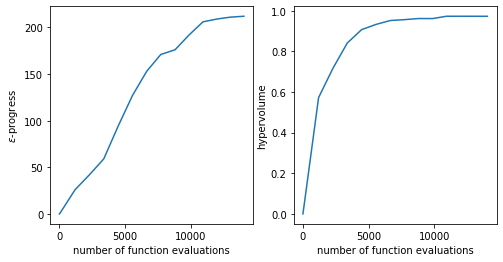

In [4]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

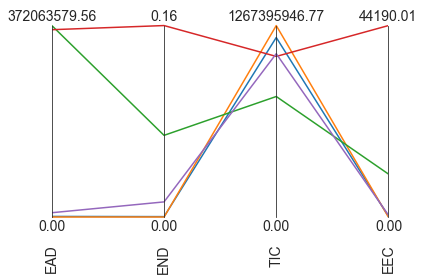

In [7]:
from ema_workbench.analysis import parcoords

data = results1.loc[:,['EAD', 'END', 'TIC', 'EEC']]
limits = parcoords.get_limits(data)
limits.loc[0, ['EAD', 'END', 'TIC', 'EEC']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

## Step 2.2 Run sollutions under KPI's Gelderland

Hier laden we de nieuwe PF, kopiëren we de results van optimize functie en daarmee runnen we een aantal experimenten. Hoeft niet veel want is alleen om op basis van deze KPI's te filteren. Hierna gaan we echt runnen en testen voor robustness

In [11]:
#First copy resutls and remove outcomes (leave just the policy)
results_optimize_copy = results1
policies_values = results_optimize_copy.drop(columns=['EAD', 'END', 'TIC', 'EEC'])
policies = []
for i, policy in policies_values.iterrows():
    policies.append(Policy(str(i), **policy.to_dict()))
    
dike_model, planning_steps = get_model_for_problem_formulation(6)

with MultiprocessingEvaluator(dike_model) as evaluator:
    resultsKPI = perform_experiments(dike_model, scenarios=200, policies=policies, evaluator=evaluator) 
    experiments, outcomes = resultsKPI
    
outcomes_df = pd.DataFrame(outcomes)
experiments.to_excel('./export/resultsKPI_experiments.xlsx')
outcomes_df.to_excel('./export/resultsKPI_outcomes.xlsx')

# experiments = pd.read_excel('./export/resultsKPI_experiments.xlsx', index_col=0, )
# outcomes_df = pd.read_excel('./export/resultsKPI_outcomes.xlsx', index_col=0, )

[MainProcess/INFO] performing 2 scenarios * 5 policies * 1 model(s) = 10 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] 2 cases completed
[MainProcess/INFO] 3 cases completed
[MainProcess/INFO] 4 cases completed
[MainProcess/INFO] 5 cases completed
[MainProcess/INFO] 6 cases completed
[MainProcess/INFO] 7 cases completed
[MainProcess/INFO] 8 cases completed
[MainProcess/INFO] 9 cases completed
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] experiments finished


In [13]:
outcomes_df

,A1/2_EAD,A1/2_END,A3_EAD,A3_END,G_TIC,EEC
0,0.000000e+00,0.000000,0.000000e+00,0.000000,1.055763e+09,0.000000
1,0.000000e+00,0.000000,0.000000e+00,0.000000,1.055763e+09,0.000000
2,0.000000e+00,0.000000,0.000000e+00,0.000000,1.073565e+09,0.000000
3,0.000000e+00,0.000000,0.000000e+00,0.000000,1.073565e+09,1155.969642
4,5.754864e+06,0.000986,0.000000e+00,0.000000,5.760533e+08,180.245241
5,5.841240e+08,0.104631,0.000000e+00,0.000000,5.760533e+08,14298.891782
6,0.000000e+00,0.000000,6.873596e+06,0.002887,8.465611e+08,665.566921
7,0.000000e+00,0.000000,1.577993e+07,0.007935,8.465611e+08,5164.461994
8,0.000000e+00,0.000000,0.000000e+00,0.000000,9.654102e+08,659.826826
9,0.000000e+00,0.000000,0.000000e+00,0.000000,9.654102e+08,11309.562041


## Step 3: Re-evaluate candidate solutions under uncertainty
For this, I selected all policies where fewest deaths are fallen. But this could also be adapted to fewest 20% G_TIC or some other goals we have

In [16]:
resultsKPI_filter = resultsKPI
indexNames = resultsKPI_filter[ resultsKPI['A1/2_END'] > np.percentile(resultsKPI['A1/2_END'],50) ].index
resultsKPI_filter.drop(indexNames , inplace=True)
indexNames = resultsKPI_filter[ resultsKPI['A3_END'] > np.percentile(resultsKPI['A3_END'],50) ].index
resultsKPI_filter.drop(indexNames , inplace=True)

TypeError: tuple indices must be integers or slices, not str

In [9]:
resultsKPI_filter

,0_RfR 0,1_RfR 0,2_RfR 0,3_RfR 0,4_RfR 0,EWS_DaysToThreat,A.1_DikeIncrease 0,A.2_DikeIncrease 0,A.3_DikeIncrease 0,A.4_DikeIncrease 0,A.5_DikeIncrease 0,A1/2_EAD,A1/2_END,A3_EAD,A3_END,G_TIC,EEC,TAC
1,0,0,0,0,0,2,4,2,1,0,7,9.073869e+06,0.000659,0.000000e+00,0.000000,1.109657e+08,262.710561,1.668717e+08
4,0,0,0,0,0,2,4,3,1,0,7,2.136422e+06,0.000158,4.050047e+06,0.000557,1.159899e+08,184.057027,1.690880e+08
8,0,0,0,0,0,3,4,1,1,0,6,1.585695e+07,0.000911,0.000000e+00,0.000000,1.063924e+08,442.668666,1.631153e+08
10,0,0,0,0,0,2,4,4,1,0,7,0.000000e+00,0.000000,4.050047e+06,0.000557,1.215058e+08,138.559055,1.724674e+08
13,0,0,1,0,0,2,4,0,0,0,6,2.658551e+07,0.001860,0.000000e+00,0.000000,7.854795e+07,591.457911,1.460022e+08
15,0,0,0,0,0,1,4,3,2,0,7,2.136422e+06,0.000379,0.000000e+00,0.000000,1.178585e+08,69.200304,1.669064e+08
16,0,0,0,0,0,0,4,4,2,0,7,0.000000e+00,0.000000,0.000000e+00,0.000000,1.233743e+08,0.000000,1.702858e+08


In [10]:
policies_values = resultsKPI_filter.drop(columns=['A1/2_EAD', 'A1/2_END', 'A3_EAD', 'A3_END', 'G_TIC', 'EEC', 'TAC'])
policies = []
for i, policy in policies_values.iterrows():
    policies.append(Policy(str(i), **policy.to_dict()))

In [74]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = perform_experiments(dike_model, scenarios=2000, policies=policies, evaluator=evaluator)
    experiments, outcomes = results
    
outcomes_df = pd.DataFrame(outcomes)
experiments.to_excel('./export/resultsKPI_filter_experiments.xlsx')
outcomes_df.to_excel('./export/resultsKPI_filter_outcomes.xlsx')

# experiments = pd.read_excel('./export/resultsKPI_filter_experiments.xlsx', index_col=0, )
# outcomes_df = pd.read_excel('./export/resultsKPI_filter_outcomes.xlsx', index_col=0, )

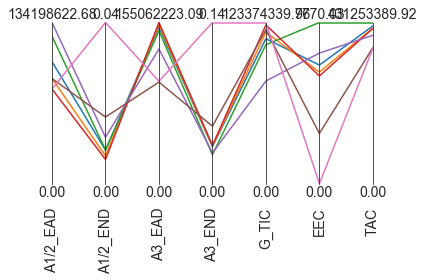

In [75]:
# Versie 4, code van maarten: Volgens mij is deze maximaal efficient :)
outcomes_mean = pd.DataFrame()
single_mean = {}

for policy in np.unique(experiments['policy']): #loop x times for x different unique policies
    logical = experiments['policy']==policy #series of true/false for policy iteration
    for key in outcomes_df.keys(): #loop x times for each key in outcomes
        single_mean[key] = np.mean(outcomes_df[key][logical])
    outcomes_mean = outcomes_mean.append(pd.DataFrame(single_mean, index = [policy]))

data = outcomes_mean
limits = parcoords.get_limits(data)
limits.loc[0, ['A1/2_EAD', 'A1/2_END', 'A3_EAD', 'A3_END', 'G_TIC', 'EEC', 'TAC']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

In [14]:
outcomes_mean

,A1/2_EAD,A1/2_END,A3_EAD,A3_END,G_TIC,EEC,TAC
1,1.015173e+08,0.008754,1.506900e+08,0.031827,1.109657e+08,7187.499104,4.220818e+08
4,8.748537e+07,0.007254,1.529413e+08,0.032319,1.159899e+08,6760.567229,4.159758e+08
8,1.227626e+08,0.008797,1.470746e+08,0.024787,1.063924e+08,9770.027092,4.312534e+08
10,7.876951e+07,0.006319,1.550622e+08,0.032815,1.215058e+08,6527.107425,4.152338e+08
13,1.341986e+08,0.012114,1.296216e+08,0.026393,7.854795e+07,7913.489868,3.970799e+08
15,8.748537e+07,0.017409,9.764968e+07,0.049436,1.178585e+08,3036.799722,3.638633e+08
16,7.876951e+07,0.042124,9.854017e+07,0.138728,1.233743e+08,0.000000,3.619382e+08


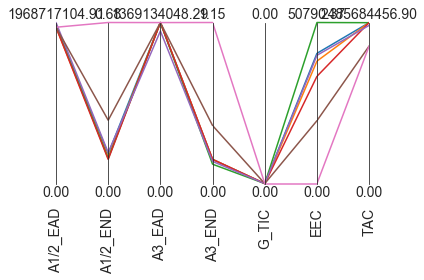

In [15]:
max_regret = pd.DataFrame()
single_regret = {}

for policy in np.unique(experiments['policy']): #loop x times for x different unique policies
    logical = experiments['policy']==policy #series of true/false for policy iteration
    for key in outcomes_df.keys(): #loop x times for each key in outcomes
        single_regret[key] = np.max(outcomes_df[key][logical])-np.min(outcomes_df[key][logical])
    max_regret = max_regret.append(pd.DataFrame(single_regret, index = [policy]))

data = max_regret
limits = parcoords.get_limits(data)
limits.loc[0, ['A1/2_EAD', 'A1/2_END', 'A3_EAD', 'A3_END', 'G_TIC', 'EEC', 'TAC']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

C:\Program Files (x86)\Anaconda\lib\site-packages\ema_workbench\analysis\parcoords.py:198: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


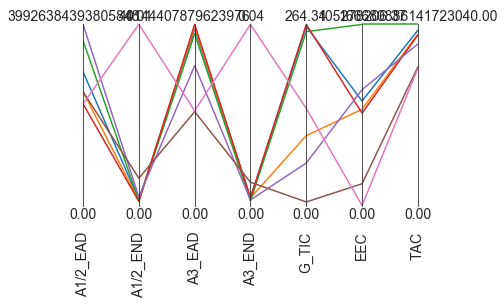

In [16]:
# Versie 4, code van maarten: Volgens mij is deze maximaal efficient :)
signal_to_noise = pd.DataFrame()
signal_single = {}

for policy in np.unique(experiments['policy']): #loop x times for x different unique policies
    logical = experiments['policy']==policy #series of true/false for policy iteration
    for key in outcomes_df.keys(): #loop x times for each key in outcomes
        signal_single[key] = np.mean(outcomes_df[key][logical])*np.std(outcomes_df[key][logical])
    signal_to_noise = signal_to_noise.append(pd.DataFrame(signal_single, index = [policy]))

data = signal_to_noise
limits = parcoords.get_limits(data)
limits.loc[0, ['A1/2_EAD', 'A1/2_END', 'A3_EAD', 'A3_END', 'G_TIC', 'EEC', 'TAC']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()